# Chapter 3: Journey to the Frozen Sea

In this chapter, we'll delve into sea ice and the clear evidence it presents of our shifting climate. We'll employ satellite data to explore various attributes of sea ice in both the Arctic and Antarctic.

<div class="alert alert-block alert-success">
<b>Objective:</b> <br>
   Recreate figures from the <a href="https://climate.copernicus.eu/climate-intelligence">C3S Climate Intelligence</a> reports concerning sea ice. In particular, we'll replicate figures from the sea ice segments of the <a href="https://climate.copernicus.eu/climate-bulletins">Monthly Climate Bulletins</a> and <a href="https://climate.copernicus.eu/climate-indicators/sea-ice">Climate Indicators</a>.
</div>

### Background

The data set for our analysis is furnished by the European Organisation for the Exploitation of Meteorological Satellites (<a href="https://www.eumetsat.int/">EUMETSAT</a>). EUMETSAT is a pivotal operational satellite agency located in the heart of Europe, supplying data, products, and support to a vast array of users, both in Europe and globally.

The <a href="https://osi-saf.eumetsat.int/">OSI SAF</a> (Ocean and Sea Ice Satellite Application Facility) is one of the specialist Satellite Application Facilities (SAFs) under EUMETSAT. These SAFs are dedicated hubs for satellite data processing, each concentrating on different thematic areas. As implied by its name, the OSI SAF is committed to offering operational products and services pertaining to the ocean and [sea ice](https://osi-saf.eumetsat.int/products/sea-ice-products).

In this guide, we'll examine various facets of global sea ice, focusing on:

- **Sea Ice Concentration (SIC)**: The portion of a grid cell blanketed with sea ice.
- **Sea Ice Extent (SIE)**: The aggregate area of all grid cells with a minimum of 15% ice concentration.
- **Sea Ice Area**: The cumulative area covered by sea ice. This is calculated by multiplying grid cell areas by their respective sea ice concentrations and summing the outcomes.
- **Sea Ice Edge**: The sea surface is categorised as open water, open ice, or closed ice, contingent on the quantity of sea ice in each grid cell. A sea ice concentration benchmark of 30% is employed to differentiate between open water and open ice.
- **Sea Ice Type**: Sea ice-covered expanses are generally divided into two categories based on the sea ice's age: multiyear ice and seasonal first-year ice.

### Overview of Datasets

The bulk of the datasets are sourced from the [MET Norway Thredds Service](https://thredds.met.no/thredds/osisaf/osisaf.html) affiliated with the Norwegian Meteorological Institute. Some datasets are accessible via the Climate Data Store (CDS). One exception is the Sea Ice Index, which outlines sea ice extent in both the Arctic and Antarctic and is exclusively provided by OSI SAF. Conversely, the C3S furnishes a unique product dedicated to the sea ice edge and type, available solely through the CDS.

During our exploration in this notebook, we'll employ the following datasets:

| Variable | Provider | MET Norway Thredds Service | Climate Data Store |
|---------|:-------------:|:------:|:------:|  
| Sea ice concentration | EUMETSAT OSI SAF | [CDR v3.0](https://osi-saf.eumetsat.int/products/osi-430-a) (OSI-450-a) / [ICDR v3.0](https://osi-saf.eumetsat.int/products/osi-450-a) (OSI-430-a) | [Yes](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview) |
| Sea ice extent | EUMETSAT OSI SAF | [Sea Ice Index v2.2](https://osi-saf.eumetsat.int/products/osi-420) | -- |
| Sea ice edge/type | C3S/CDS | -- | [Yes](https://doi.org/10.24381/cds.29c46d83)


<div class="alert alert-block alert-warning">
<b>Caution</b>: <br>
   This notebook is notably data-heavy and necessitates roughly 100 GB of free disk space. Cells in the notebook that initiate a download will be preceded by a warning cell.
</div>

<div class="alert alert-block alert-info">    
<b>NOTE</b>: 
Before interacting with the following notebook, please ensure you've reviewed the <a href="https://ecmwfcode4earth.github.io/sketchbook-earth/how_to_run_notebooks.html">How to Execute the Notebooks</a> section.
</div>

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ECMWFCode4Earth/sketchbook-earth/main?labpath=tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------

### Importing Packages

In [1]:
# Standard libraries
import os
import glob

# Data handling and processing
import cdsapi
import xarray as xr
import numpy as np
import dask
from dask.diagnostics.progress import ProgressBar

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean as cmo
from tqdm.notebook import tqdm
import matplotlib.dates as dates
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath

# Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Use the cell below to apply this book's visualisation style, ensuring uniformity in plots throughout the notebook. Bear in mind this cell solely affects visualisation and won't impact the calculations in this notebook. If you're using GoogleColab, the matplotlib stylesheet won't be accessible.

In [2]:
plt.style.use("../copernicus.mplstyle")

Take care not to create large dask chunks to enhance [dask performance](https://docs.dask.org/en/latest/understanding-performance.html):

In [3]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

### Getting Started

Set the reference period that dictates the climatology of our records. As we're dealing with data with time coordinates based on either daily `datetime` or yearly `int` values, we'll establish the reference period for both instances.

In [4]:
REF_PERIOD_YEARS = {'year': slice(1991, 2020)}
REF_PERIOD_DATETIME = {'time': slice('1991-01-01', '2020-12-31')}

Next, let's set up a data directory to organise our files.

In [5]:
path_to = {}  # dictionary containing [<variable> : <target folder>]

path_to.update({"ice_conc": "data/concentration/"})
path_to.update({"ice_conc_processed": "data/concentration/processed/"})
path_to.update({"ice_extent": "data/extent/"})
path_to.update({"ice_edge": "data/edge/"})
path_to.update({"ice_type": "data/type/"})

for file, path in path_to.items():
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print("{:<20} --> {}".format(file, path))

ice_conc             --> data/concentration/
ice_conc_processed   --> data/concentration/processed/
ice_extent           --> data/extent/
ice_edge             --> data/edge/
ice_type             --> data/type/


### Sea Ice Concentration

We'll begin by downloading and analysing the sea ice concentration, as it underpins other sea ice metrics such as extent, area, and edge. Initially, we'll visualise sea ice extent anomalies for a specific month, focusing on the Arctic. But we'll also demonstrate how to sidestep the rigorous data processing for sea ice extent using the OSI SAF Sea Ice Index, allowing us to observe recent shifts in the Antarctic too. 

#### Downloading from CDS

The sea ice concentration (SIC) is obtainable via the [CDS](https://doi.org/10.24381/cds.3cd8b812) as a daily gridded data set from 1979 onwards. Owing to the size of the entire dataset, we'll only fetch specific months required for the reproduction of the C3S Climate Intelligence reports - specifically January to March and September. We'll use the CDS API to download the data, storing it in the previously created data directory. To optimise the download, we'll batch it monthly.

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
   At the time of writing, the Climate Data Store offers version 2 of the dataset, not the latest version 3. If you need version 3, consider downloading directly from the <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>

Next, we'll devise a function that takes a CDS `Client` object, along with the desired year and month to be downloaded and a destination path for the file. As the data comes in `tgz` format, it'll be necessary to unpack the file post-download. The final step in the process will discard the tar file to conserve disk space.

In [7]:
DAYS = ["{:02d}".format(d) for d in range(1, 32)]

def download_sea_ice_concentration(client, year, month, save_to):
    client.retrieve(
        "satellite-sea-ice-concentration",
        {
            "version": "v2",
            "variable": "all",
            "format": "tgz",
            "origin": "eumetsat_osi_saf",
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
        },
        save_to,
    )
    # Untar and then remove tar file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


To initiate the download using the `cdsapi`, we must supply our CDS API key.

In [8]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################' # add your key here the format should be as {uid}:{api-key}

<div class="alert alert-block alert-info">
<b>New to CDS?</b> Consider the <a href="https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html">CDS tutorial</a> for a detailed guide.
</div>

Then, we can launch the CDS client. We're muting the rather verbose `cdsapi` output by adjusting the `quiet` and `progress` parameters, and we'll use `tqdm` to monitor the overall download progression.

In [407]:
client = cdsapi.Client(url=URL, key=KEY, quiet=True, progress=False)

Next, we'll specify the years and months to download. We're fetching data for January to March and September spanning from 1979 to 2022.

In [9]:
YEARS = ["{:04d}".format(y) for y in range(1979, 2023)]
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3, 9]]  # Note: only Jan, Feb, Mar and Sep are downloaded

Now, we'll iterate through our selected years and months, saving the files in the data directory. If the download is interrupted, simply re-run the cell, and it will bypass previously fetched files.

<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
   The upcoming cell will download approximately 40 GB. Ensure you have sufficient storage space. Depending on your internet speed, this could take several hours.
</div>

In [ ]:
for year in tqdm(YEARS, desc="Overall progress"):
    for month in tqdm(MONTHS, desc="Year {}".format(year), leave=False):
        # Define the filename and the path to save the file
        filename = f"EUMETSAT_OSI_SAF_SIC_{year}_{month}.tar.gz"
        save_to = os.path.join(path_to["concentration"], filename)
        # Check if the extracted files already exist
        files_in_dir = glob.glob(f"data/concentration/*{year}{month}*.nc")
        skip_file = len(files_in_dir) > 0
        # Download the file only if it doesn"t exist
        if not skip_file:
            download_sea_ice_concentration(client, year, month, save_to)

#### Lazy Loading

Given the dataset's size, there's a risk of memory overflow if we try to load all the data simultaneously. To avoid this, we'll employ *lazy loading*, delaying data fetching until absolutely necessary. The tool `dask` can assist, only loading and processing segments (chunks) that our memory can handle, culminating in the final outcome.

Firstly, we'll inspect a file to grasp its contents.

In [10]:
da = xr.open_dataset("data/concentration/ice_conc_nh_ease2-250_icdr-v2p0_202209301200.nc")
da

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 2022-09-30T12:00:00
  * xc                        (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                        (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_conc                  (time, yc, xc) float64 ...
    raw_ice_conc_values       (time, yc, xc) float64 ...
    total_standard_error      (time, yc, xc) float64 ...
    smearing_standard_error   (time, yc, xc) float64 ...
    algorithm_standard_error  (time, yc, xc) float64 ...
    status_flag               (time, yc, xc) float32 ...
Attributes: (12/41)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.62393
    ...                        ...
    tracking_id:               40d1b998-ea2b-4d1e-b761-0b501e06448c
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v65, 09 April 2019)
    product_id:                osi-430-b
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            demonstration

It's clear the file is extensive, encompassing not just the sea ice concentration but additional variables pertinent to preprocessing, data accuracy, and quality. For our needs, we're only concerned with the `ice_conc` variable.

Additionally, spatial data coordinates are shown as `xc` and `yc`, which translate to `lat` and `lon`. The main distinction is while `xc` and `yc` depict grid cells of a consistent size (25 km, as outlined in the CDS data overview) within a Lambert Azimuthal Equal Area projection, the latitude and longitude system doesn't maintain grid cell area. As we'll discover, the `xc` and `yc` coordinates are more practical, so we'll retain them and omit the `lat` and `lon` coordinates to save memory.

We'll then load the data into an `xr.Dataset` object. The `xr.open_mfdataset` method lets us open all the files simultaneously. Crucially, this won't load the data into memory straight away; instead, it'll be fetched lazily, providing a helpful feature of `xarray` that permits large dataset management without memory complications.

To hasten the lazy loading, we'll use a preprocess function. This allows us to eliminate the `lat` and `lon` coordinates and select only the `ice_conc` variable before the individual files are merged.

In [11]:
def return_sic_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_conc']

It's now time to fetch the data, though be aware it may take several minutes.

In [12]:
sic = xr.open_mfdataset(path_to['ice_conc'] + "/*.nc", preprocess=return_sic_only)
sic

<xarray.Dataset>
Dimensions:   (time: 3735, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

#### Preprocessing

An essential element when deriving the sea ice extent anomalies for a particular month is the transition from a daily to a monthly product. As detailed in the [About the Data](https://climate.copernicus.eu/climate-indicators/about-data#Seaiceindicator) section of the C3S Climate Indicators, the monthly sea ice concentration is determined by averaging the daily values for each grid cell. However, as the data are only available every other day during the period when the SMMR sensor data are utilised, the gridded data are first linearly interpolated in time, prior to monthly averages being calculated.

The ensuing function will produce a daily index for a given Dataset object, reindex the data to the daily index, and then interpolate the data linearly over time. The resulting Dataset object will then have daily sea ice concentration values for each grid cell. Note that we will only interpolate the data for September, as delineated in the *About the Data* section above.

In [13]:
def interpolate_daily(da):
    months = np.unique(da.time.dt.month)
    # Create a daily time index
    daily_index = xr.date_range(start=da.time[0].values,end=da.time[-1].values, freq='D')
    # Only consider the months that are in the data
    daily_index = daily_index[daily_index.month.isin(months)]
    # Reindex the data to the daily time index
    da_reindexed = da.reindex(time=daily_index)
    # Rechunk the data in space to speed up the interpolation
    da_reindexed = da_reindexed.chunk(dict(time=-1, xc=50, yc=50))
    # Interpolate the missing values
    return da_reindexed.interpolate_na("time")

is_september = sic.time.dt.month == 9
sic_september = sic.sel(time=is_september)
sic_interp = interpolate_daily(sic_september)
sic_interp["ice_conc"]

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.DataArray 'ice_conc' (time: 1320, yc: 432, xc: 432)>
dask.array<transpose, shape=(1320, 432, 432), dtype=float64, chunksize=(1320, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...

One of the primary benefits of `dask` is the ability to chain operations until our processed dataset can comfortably fit into memory. But, computing the same `dask` DataArray multiple times can be time-consuming. Thus, let's calculate this intermediate result, save it to disk, and lazily reload it for further processing.

In [14]:
path_to_processed_sic = path_to['ice_conc_processed'] + "ice_conc_interpolated.nc"

with ProgressBar():
    sic_interp.to_netcdf(path_to_processed_sic)

[########################################] | 100% Completed | 45.45 s


Let's reload our dataset, again using a `dask` DataArray. 

Given that we'll be working with spatial dimensions to compute the sea ice extent (specifically, totting up the grid cells blanketed in ice), it's essential to structure our data in chunks by time. This ensures that every chunk loaded contains the full set of information required for the calculation. By setting the chunks of a dimension to $-1$, we're indicating our preference not to chunk along that specific dimension.

In [15]:
chunks = dict(time=50, xc=-1, yc=-1)
with xr.open_mfdataset(path_to_processed_sic, chunks=chunks) as sic_interp:
    pass

### Sea Ice Extent

In our introduction, we touched on the concept of sea ice extent, which represents the total area engulfed by sea ice at any given time. For a grid cell to be deemed ice-covered, the sea ice concentration needs to be at least 15%. According to the CDS overview page, this data is depicted using a Lambert Azimuthal Equal Area projection centred over the poles, with a grid resolution of 25 km. Let's verify this by examining the dataset's coordinates, specifically the step size of the `xc` and `yc` coordinates.

In [16]:
print(sic_interp.coords['xc'].diff('xc').values[:5])
print(sic_interp.coords['yc'].diff('yc').values[:5])

[25. 25. 25. 25. 25.]
[-25. -25. -25. -25. -25.]


As anticipated, both coordinates have a step size of 25 km. Hence, each grid cell embodies an area of $(25 \text{km})^2= 625 \text{km}^2$. The sea ice extent can be deduced by multiplying this area by the count of ice-covered grid cells.

In [17]:
is_covered = sic_interp['ice_conc'] >= 15
ice_extent = (is_covered * 25**2).sum(('yc', 'xc'))
ice_extent

<xarray.DataArray 'ice_conc' (time: 1320)>
dask.array<sum-aggregate, shape=(1320,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01T12:00:00 ... 2022-09-30T12:00:00

Given the compact nature of this time series, it can comfortably fit into memory. Let's crunch the numbers!

In [18]:
with ProgressBar():
    ice_extent = ice_extent.compute()
    


[########################################] | 100% Completed | 3.78 sms


From the daily readings, we can derive monthly averages.

In [19]:
ice_extent_monthly = ice_extent.resample(time='1M').mean()

In order to compute anomalies, we'll first have to compute the reference climatology.

In [20]:
ice_extent_monthly_clim = ice_extent_monthly.sel(REF_PERIOD_DATETIME).mean('time')
ice_extent_monthly_anomaly = ice_extent_monthly - ice_extent_monthly_clim

The subsequent step is computing the relative monthly anomaly of sea ice extent. An illustration of this is provided in Figure 1 of both Monthly Climate Bulletins and Climate Indicators.

In [21]:

ice_extent_monthly_anomaly_relative = ice_extent_monthly_anomaly / ice_extent_monthly_clim * 100 # in percent

For ease of visualisation, we'll adopt more concise handles.

In [22]:
time_steps = ice_extent_monthly_anomaly_relative.time
data = ice_extent_monthly_anomaly_relative

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


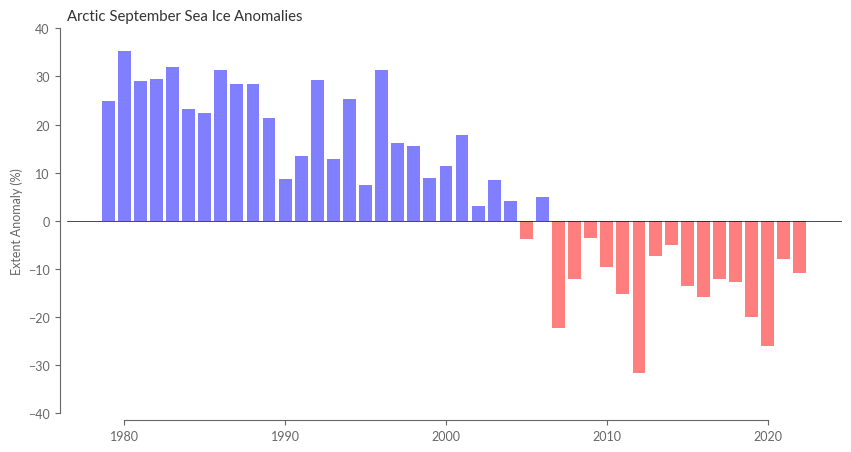

In [23]:
# define colors to be blue for positive and red for negative anomalies
colors = ['blue' if x >= 0 else 'red' for x in data]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.bar(data.time.dt.year, data, color=colors, alpha=.5)
ax.axhline(0, color='black', linewidth=.5)
ax.set_title('Arctic September Sea Ice Anomalies')
ax.set_ylabel('Extent Anomaly (%)')
ax.set_ylim(-40, 40)
sns.despine(ax=ax, offset=5, trim=True)
plt.show()

### Sea Ice Extent (Less Data-Intensive Alternative)

In the preceding section, we detailed the methodology for discerning the Arctic's sea ice extent based on its concentration. While this approach is straightforward, the sheer volume of data involved might prove cumbersome for some users. An alternative is the OSI SAF's [Sea Ice Index](https://osi-saf.eumetsat.int/products/osi-420), a dedicated product for sea ice extent that encompasses both the Arctic and Antarctic. This is derived from sea ice concentration data but offers the advantage of being pre-processed, minimising data processing requirements.

  


To access the Sea Ice Index, we'll tap into the [MET Norway Thredds Service](https://thredds.met.no/thredds/osisaf/osisaf.html) offered by the Norwegian Meteorological Institute. Available in `netCDF` format, the data can be directly sourced from the [Thredds server](https://thredds.met.no/thredds/osisaf/osisaf_seaiceindex.html). Direct links to fetch the index for the [Northern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/nh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc) and [Southern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/sh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc) are provided.

In [6]:
url_northern_hemisphere = "https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc"
url_southern_hemisphere = "https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc" 

sie_nh = xr.open_dataset(url_northern_hemisphere)
sie_sh = xr.open_dataset(url_southern_hemisphere)
sie_nh

<xarray.Dataset>
Dimensions:        (time: 16399, nv: 2)
Coordinates:
  * time           (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-09-17
    sic_threshold  float32 ...
    lat            float32 ...
    lon            float32 ...
Dimensions without coordinates: nv
Data variables:
    lat_bounds     (nv) float32 ...
    lon_bounds     (nv) float32 ...
    area           |S64 ...
    sie            (time) float64 ...
    source         (time) float64 ...
Attributes: (12/35)
    title:                   Daily Northern Hemisphere Sea Ice Extent from EU...
    product_id:              OSI-420
    product_name:            OSI SAF Sea Ice Index
    product_status:          demonstration
    version:                 v2p2
    summary:                 Time series of Daily Sea Ice Extent (SIE) for No...
    ...                      ...
    distribution_statement:  Free
    copyright_statement:     Copyright 2023 EUMETSAT
    references:              Product User Manual for OSI-420, Lavergne et al....
    featureType:             timeSeries
    DODS.strlen:             2
    DODS.dimName:            nchar

Our initial step is to tidy up the datasets,

In [7]:
sie_nh = sie_nh.drop_vars(["lat", "lon", "sic_threshold"])
sie_sh = sie_sh.drop_vars(["lat", "lon", "sic_threshold"])

and subsequently merge them into a single `Dataset`, featuring variables for both the `Arctic` and the `Antarctic`.

In [8]:
sie = xr.Dataset({
    "Arctic": sie_nh["sie"],
    "Antarctic": sie_sh["sie"],
})
sie

<xarray.Dataset>
Dimensions:    (time: 16399)
Coordinates:
  * time       (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-09-17
Data variables:
    Arctic     (time) float64 ...
    Antarctic  (time) float64 ...

A cursory examination of our data reveals a noteworthy contrast. Unlike our original methodology, which required extensive data processing and solely gave us Arctic data for September, this alternative method grants us daily data for both hemispheres throughout the year. Plus, with only a few days' lag, this dataset is frequently updated, making it a pivotal source for tracking global sea ice extent trends.

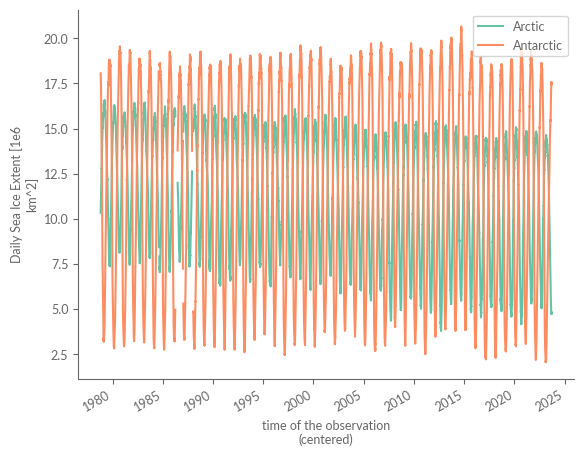

In [9]:
sie["Arctic"].plot(label="Arctic")
sie["Antarctic"].plot(label="Antarctic")
plt.legend()
plt.show()

Our subsequent task involves visualising daily sea ice extent via a line plot. For this, we'll remodel data coordinates, transitioning the `time` dimension into `year` and `dayofyear`.

In [10]:
sie["year"] = sie.time.dt.year
sie["dayofyear"] = sie.time.dt.dayofyear
sie = sie.set_index(time=["year", "dayofyear"]).unstack()
sie


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:    (year: 46, dayofyear: 366)
Coordinates:
  * year       (year) int64 1978 1979 1980 1981 1982 ... 2020 2021 2022 2023
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    Arctic     (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan
    Antarctic  (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan

Before proceeding, it's imperative to compute the daily climatology, which will serve as our plot's reference line.

In [11]:
sie_clim_median = sie.sel(REF_PERIOD_YEARS).median("year")

For data representation, we'll harness a few auxiliary functions:

- `create_line_plot`: Initiates the basic plot, creating `Figure` and `Axes`objects
- `highlight_most_recent_year`: Precisely as it sounds, this function accentuates the latest year by modifying its hue and appending a marker to its termination, signifying the most recent data point
- `center_labels_between_xticks`: A simple aesthetic enhancement, this function repositions each month's axis label to reside between the ticks. For guidance, see [here](https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html)

In [12]:
def create_line_plot(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    # Plot the data as a line for each year
    xr.plot.line(data, ax=ax, x="dayofyear", color=".5", alpha=.5, add_legend=False)
    return fig, ax

def highlight_most_recent_year(ax, data):
    # Add the most recent year as a red line
    data.isel(year=-1).plot.line(ax=ax, x="dayofyear", color="r", alpha=.5, lw=4)
    # Add text with year at the most recent data point with the same color as the line
    most_recent_data = data.isel(year=-1).dropna('dayofyear').isel(dayofyear=-1)
    ax.text(
        most_recent_data.dayofyear + 5,
        most_recent_data.values,
        most_recent_data.year.values,
        color="r",
        alpha=.5,
        fontsize=14,
        weight="bold",
        va="center",
    )
    # Mark the most recent data with a red circle
    ax.plot(
        most_recent_data.dayofyear,
        most_recent_data.values,
        "o",
        color="r",
        alpha=.75,
        markersize=10,
        markeredgewidth=0,
    )

def center_labels_between_xticks(ax):
    # set y-ticks as integers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Set major x-ticks every 1 month
    ax.xaxis.set_major_locator(dates.MonthLocator())


    # Centering labels between ticks
    # 16 is a slight approximation since months differ in number of days.
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter("%b"))

    # Remove the minor tick lines
    ax.tick_params(axis="x", which="minor", tick1On=False, tick2On=False)

    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment("center")

Choose the hemisphere you'd like to showcase on the plot.

In [36]:
region = 'Antarctic'

Now, let's get plotting!

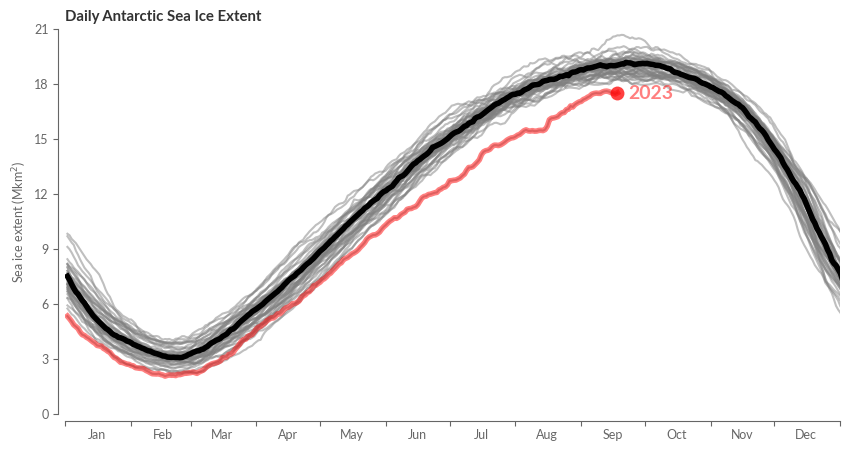

In [37]:
fig, ax = create_line_plot(sie[region])
# Add the median as a bold black line
sie_clim_median[region].plot(ax=ax, color="k", alpha=1, lw=4)
highlight_most_recent_year(ax, sie[region])
center_labels_between_xticks(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, 21)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent", weight='bold')
ax.set_ylabel("Sea ice extent (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()

We then embark on visualising the anomalies, whose calculations are rather straightforward.

In [38]:
sie_anomaly = sie - sie_clim_median

By leveraging our previously mentioned helper functions and making slight adjustments to the axes, we're set.

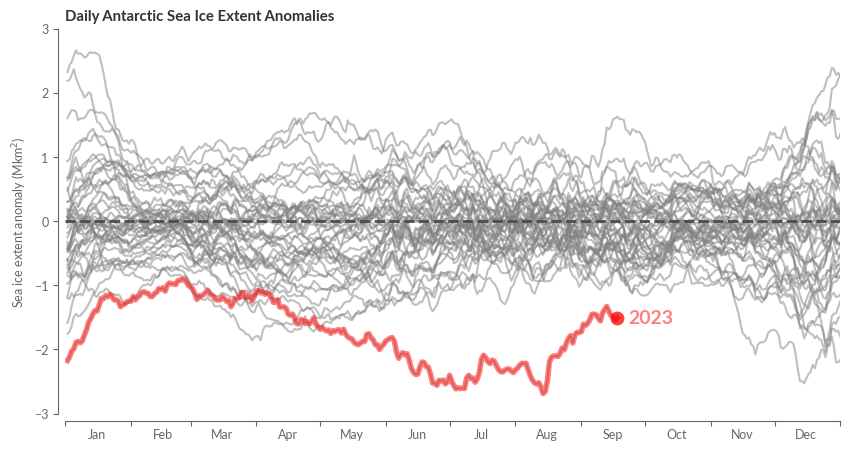

In [39]:
fig, ax = create_line_plot(sie_anomaly[region])
highlight_most_recent_year(ax, sie_anomaly[region])
center_labels_between_xticks(ax)
# Add center line
ax.axhline(0, color=".3", ls='--', lw=2)
ax.set_xlim(0, 365)
ax.set_ylim(-3, 3)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent Anomalies", weight="bold")
ax.set_ylabel("Sea ice extent anomaly (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()


Finally, let's have a look at the relative anomalies in terms of standard deviations.

In [40]:
sie_relative_anomaly = sie_anomaly / sie.sel(REF_PERIOD_YEARS).std("year")

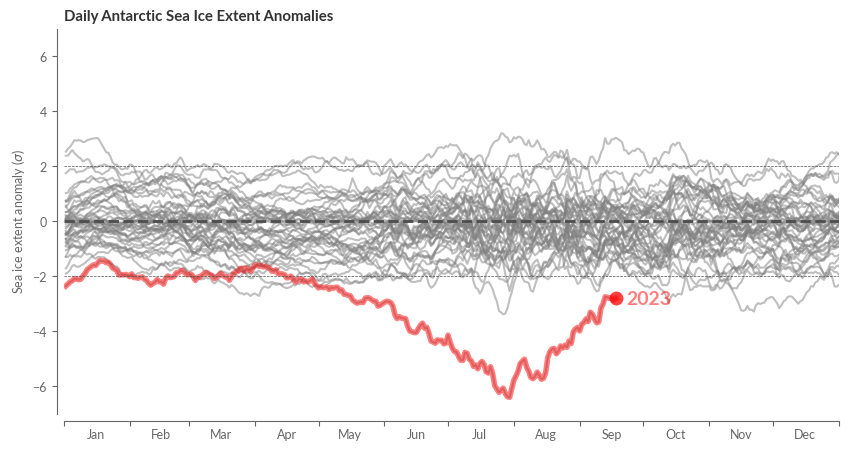

In [41]:
fig, ax = create_line_plot(sie_relative_anomaly[region])
highlight_most_recent_year(ax, sie_relative_anomaly[region])
center_labels_between_xticks(ax)
# Add center line
ax.axhline(0, color=".3", ls='--', lw=2)
ax.axhline(2, color=".3", ls='--', lw=.5)
ax.axhline(-2, color=".3", ls='--', lw=.5)
ax.set_xlim(0, 365)
ax.set_ylim(-7, 7)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent Anomalies", weight="bold")
ax.set_ylabel("Sea ice extent anomaly ($\sigma$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()

### Visualising Sea Ice Concentration

Our subsequent endeavour is to craft maps showcasing the **average sea ice concentration** for **September 2022** in the **Arctic**, alongside its associated anomaly and concentration trends. To depict other months or regions like the Antarctic, additional data pertaining to the desired month might be required.

For a benchmark, we'll also present the median sea ice edge using data sourced from C3S.

A brief note on data projection: the C3S CDS overview page clarifies that data adopts a Lambert Azimuthal Equal Area projection focused on the poles. Though the coordinate step size measures 25 km, the `cartopy` module (our projection medium) interprets data in the Lambert Azimuthal Equal Area projection in metres. Thus, before continuing, we need to transmute the coordinates into metres, ensuring any ensuing data inherits correct coordinates.

In [35]:
sic_interp.coords.update({"xc": sic.xc * 1000, "yc": sic.yc * 1000})  # Convert km to metres

Transitioning the daily concentrations into monthly averages is our next step.

In [37]:
sic_monthly = sic_interp.resample(time='1M').mean()

We'll then load the processed dataset into memory.

In [38]:
with ProgressBar():
    sic_monthly = sic_monthly.compute()

[#                                       ] | 3% Completed | 105.13 ms

[########################################] | 100% Completed | 4.70 sms


Our second quantity of interest is the anomaly, which can be computed as follows.

In [39]:
sic_monthly_clim = sic_monthly.sel(REF_PERIOD_DATETIME).groupby('time.month').mean('time')
sic_monthly_anomaly = sic_monthly.groupby('time.month') - sic_monthly_clim

Given the complexity associated with our desired plot, we've crafted helper functions to streamline the process:

- `set_circle_boundary`: this will create an axis in form of a circle, in contrast to the default rectangular form. An example of this is given on the official `cartopy` [webpage](https://scitools.org.uk/cartopy/docs/latest/gallery/lines_and_polygons/always_circular_stereo.html#sphx-glr-gallery-lines-and-polygons-always-circular-stereo-py).
- `str2float`: convert longitude representations from string to float, e.g. `60E` $\rightarrow 60.0$ or `120W` $\rightarrow -120.0$
- `rotate_labels_polar_plot`: optimal label positioning

In [41]:
def set_circle_boundary(ax):
    # Set a circle boundary for the map
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

def str2float(label):
    # Extract the numbers from the label
    number = ''.join(c for c in label if c.isdigit())
    number = float(number)
    # Longitude is negative if it is in the west of the meridian
    if 'W' in label:
        number = -number
    return number

def lon2rot(lon):
    rot_rad = lon
    if abs(lon) >= 90:
        rot_rad = lon - 180
    return rot_rad

def rotate_labels_polar_plot(ax, gridlines):
    # Rotate the labels to simplify reading them
    plt.draw()
    for label in ax.texts:
        alphanumeric_label = label.get_text()
        longitude = str2float(alphanumeric_label)
        if longitude in gridlines.xlocator.locs:
            rot_degree = lon2rot(longitude)
            label.set_rotation(rot_degree)
            label.set_horizontalalignment('center')
            label.set_verticalalignment('center')
            if abs(longitude) >= 90:
                label.set_verticalalignment('bottom')
            else:
                label.set_verticalalignment('top')
        else:
            label.set_visible(False)

Foremost, we must delineate the pertinent projections for the map (`proj_polar`) and the data (`proj_data`).

In [42]:
proj_polar = ccrs.NorthPolarStereo()
proj_data = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

The following cell produces the desired figure:

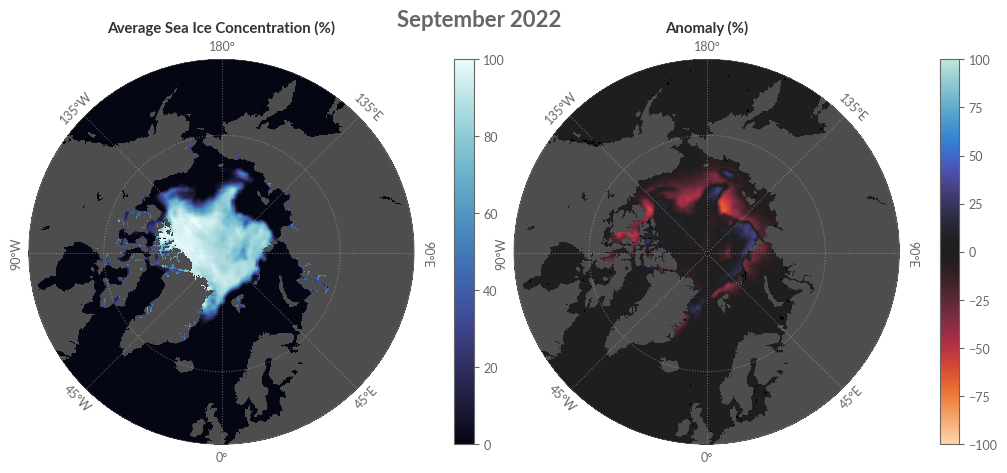

In [43]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, .05, 1, .05])
ax1 = fig.add_subplot(gs[0, 0], projection=proj_polar)
ax2 = fig.add_subplot(gs[0, 2], projection=proj_polar)
cax1 = fig.add_subplot(gs[0, 1])
cax2 = fig.add_subplot(gs[0, 3])
axes = [ax1, ax2]
for ax in axes:
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    gl = ax.gridlines(zorder=5, ls=':', lw=.75, color='.75', alpha=.5, draw_labels=True)
    gl.xlocator = ticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135, 180])
    gl.ylocator = ticker.FixedLocator([30, 65, 90])

    # ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cfeature.OCEAN, zorder=1, color='k')
    ax.add_feature(cfeature.LAND, zorder=2, color='.3')

    set_circle_boundary(ax)

sic_cbar_kws = dict(label='')
sic_anom_cbar_kws = dict(label='')
sic_kws = dict(vmin=0, vmax=100, cmap=cmo.cm.ice, zorder=3, transform=proj_data, cbar_ax=cax1, cbar_kwargs=sic_cbar_kws)
sic_anom_kws = dict(vmin=-100, vmax=100, cmap='icefire_r', zorder=3, transform=proj_data, cbar_ax=cax2, cbar_kwargs=sic_anom_cbar_kws)
sic_monthly['ice_conc'].isel(time=-1).plot.pcolormesh(ax=ax1, **sic_kws)
sic_monthly_anomaly['ice_conc'].isel(time=-1).plot.pcolormesh(ax=ax2, **sic_anom_kws)

for ax in axes:
    ax.set_title('')
    # Rotate the labels to simplify reading them
    rotate_labels_polar_plot(ax, gl)

ax1.set_title('Average Sea Ice Concentration (%)', weight='bold', loc='center')
ax2.set_title('Anomaly (%)', weight='bold', loc='center')
fig.suptitle('September 2022', weight='bold', fontsize=16)
plt.show()

### Trends in Sea Ice Concentration

We've already analysed and visualised the average sea ice concentration and its anomaly. The question now is whether the displayed anomaly is a rare occurrence or merely a standard data point in a larger trend. To determine this, we will conduct a least-squares linear regression on the monthly sea ice concentration values for each individual grid point. Our aim is to replicate [Figure 2](https://climate.copernicus.eu/climate-indicators/sea-ice) from the Climate Indicators section of the Climate Intelligence reports.


`xarray` proves to be invaluable once again with its `polyfit` method. By selecting `degree=1`, we initiate a polynomial fit of one degree, effectively a linear regression.

In [45]:
polyfit = sic_monthly.polyfit('time', 1)
polyfit

<xarray.Dataset>
Dimensions:                        (yc: 432, xc: 432, degree: 2)
Coordinates:
  * yc                             (yc) float64 5.388e+06 ... -5.388e+06
  * xc                             (xc) float64 -5.388e+06 ... 5.388e+06
  * degree                         (degree) int64 1 0
Data variables:
    ice_conc_polyfit_coefficients  (degree, yc, xc) float64 0.0 0.0 ... nan nan

The output is a `Dataset` showcasing the regression coefficients of the linear regression. The `degree` dimension distinguishes between the intercept (`degree=0`) and the slope (`degree=1`). As the underlying time dimension is represented in `datetime`, the unit of the slope coefficient is measured in $\text{nanoseconds}^{-1}$. We then extract the slope and convert its units to 1/decade.

In [74]:
trend = polyfit.ice_conc_polyfit_coefficients.sel(degree=1)
# Convert from 1/ns to 1/decade
trend = (trend * 1.e9 * 60 * 60 * 24 * 365 * 10)

Before delving into the visual representation, we shall explore another sea ice variable to better contextualise our findings.

### Sea Ice Edge

The **sea ice edge** demarcates the boundary where the continuous ice sheet fragments into the open ocean. For a deeper understanding of the data, visit the [overview webpage](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=overview) on the CDS. Our intention here is to compute the median sea ice edge over the reference period (1991-2020) to offer a comparative baseline.

To begin, we'll download the sea ice edge data from the CDS. As done previously, we'll devise a function to facilitate the monthly download from the dataset. Subsequently, we'll iterate through the predefined years and months at the notebook's outset.

In [46]:
def download_c3s_sea_ice_edge_type(client, variable, year, month, save_to):
    """Download sea ice edge/type for a given year and month from the CDS."""

    client.retrieve(
        "satellite-sea-ice-edge-type",
        {
            "format": "tgz",
            "variable": [variable],  # one of ["sea_ice_edge", "sea_ice_type",],  
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
            "version": "2_0",
        },
        save_to
    )
    # Unzip and then remove zipped file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


def download_loop_edge_type(client, variable, years, months):
    for year in tqdm(years, desc="Overall progress"):
        for month in tqdm(months, desc="Year {}".format(year), leave=False):
            # Define the filename and the path to save the file
            filename = f"EUMETSAT_OSI_SAF_{year}_{month}.tar.gz"
            save_to = os.path.join(path_to[variable], filename)
            # Check if the extracted files already exist
            path_dir = os.path.dirname(save_to)
            file_name_pattern = os.path.join(path_dir, f"*{year}{month}*.nc")
            # Get all files in the directory that match the pattern
            files_in_dir = glob.glob(file_name_pattern)
            file_already_exists = len(files_in_dir) > 0
            # Download the file if it doesn't exist
            if not file_already_exists:
                download_c3s_sea_ice_edge_type(client, variable, year, month, save_to)

<div class="alert alert-block alert-warning">
<b>Caution</b>: <br>
   The subsequent cell will download roughly 40 GB. Ensure sufficient storage space and, depending on your internet speed, set aside a few hours for the download.
</div>

In [ ]:
download_loop_edge_type(client=client, variable='sea_ice_edge', years=YEARS, months=MONTHS)

Let's inspect one file:

In [47]:
with xr.open_dataset("data/edge/ice_edge_nh_ease2-125_cdr-v2p0_197902011200.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:                 (time: 1, nv: 2, xc: 864, yc: 864)
Coordinates:
  * time                    (time) datetime64[ns] 1979-02-01T12:00:00
  * xc                      (xc) float64 -5.394e+03 -5.381e+03 ... 5.394e+03
  * yc                      (yc) float64 5.394e+03 5.381e+03 ... -5.394e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    time_bnds               (time, nv) datetime64[ns] ...
    ice_edge                (time, yc, xc) float32 ...
    uncertainty             (time, yc, xc) float32 ...
    status_flag             (time, yc, xc) float32 ...
Attributes: (12/43)
    title:                     Sea Ice Edge
    summary:                   Daily gridded Level-4 Sea Ice Edge Climate Dat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    ...                        ...
    processing_level:          Level-4 (l4)
    tracking_id:               7905b5d9-d8f8-4260-9edb-86bb27b88d8b
    doi:                       https://doi.org/10.24381/cds.29c46d83
    naming_authority:          no.met
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)

The procured dataset offers comprehensive data on errors and uncertainties. However, for our current purpose, which is the sea ice edge, we'll discard additional variables that bloat the dataset.

In [49]:
def return_edge_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_edge']

We'll then open the dataset as a `dask` `DataArray`, and rechunk along the `time` dimension, thus optimizing for spatial operations.

In [50]:
ice_edge = xr.open_mfdataset(path_to['ice_edge'] + "/*.nc", preprocess=return_edge_only)
ice_edge

<xarray.Dataset>
Dimensions:   (time: 3524, xc: 864, yc: 864)
Coordinates:
  * time      (time) datetime64[ns] 1979-02-01T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.394e+03 -5.381e+03 ... 5.381e+03 5.394e+03
  * yc        (yc) float64 5.394e+03 5.381e+03 ... -5.381e+03 -5.394e+03
Data variables:
    ice_edge  (time, yc, xc) float32 dask.array<chunksize=(1, 864, 864), meta=np.ndarray>

In [51]:
ice_edge = ice_edge.chunk({'time': -1, 'xc': 50, 'yc': 50})
ice_edge.ice_edge

<xarray.DataArray 'ice_edge' (time: 3524, yc: 864, xc: 864)>
dask.array<rechunk-merge, shape=(3524, 864, 864), dtype=float32, chunksize=(3524, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.394e+03 -5.381e+03 ... 5.381e+03 5.394e+03
  * yc       (yc) float64 5.394e+03 5.381e+03 ... -5.381e+03 -5.394e+03
Attributes:
    long_name:            Classification of sea surface into the classes of o...
    standard_name:        sea_ice_classification
    valid_min:            1
    valid_max:            3
    grid_mapping:         Lambert_Azimuthal_Grid
    flag_values:          [1 2 3]
    flag_meanings:        open_water open_ice closed_ice
    flag_descriptions:    flag 1: No ice or very open ice (less than 30% ice ...
    ancillary_variables:  uncertainty status_flag
    comment:              this field is the primary sea ice edge estimate for...

The `DataArray`'s attributes reveal that the data is categorised as integers, with the following interpretations:

- 1: No ice or very open ice (less than 30 % ice concentration)
- 2: Open ice (30-70 % ice concentration)
- 3: Closed ice (more than 70 % ice concentration)

Given our focus on September's sea ice concentration trends, we'll choose the respective month for the sea ice edge dataset. Since our primary interest lies in the median sea ice edge during our reference timeframe, we'll restrict our data to the years between 1991 and 2020.

In [52]:
ice_edge_september = ice_edge.sel(time=ice_edge.time.dt.month == 9)
ice_edge_ref_period = ice_edge_september.sel(REF_PERIOD_DATETIME)

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


The median sea ice edge shown in the trend maps is defined as the contour line along which grid cells have a 50% probability of being classified as open water or open ice in the daily gridded sea ice edge product. That is, we want to first reclassify the data into a binary data set (`True` or `False`) representing ice (i.e. all categories $\geq 2$) or no ice (i.e. all categories $\leq 1$).

In [104]:
ice_edge = ice_edge_ref_period['ice_edge']
is_ice = ice_edge.where(ice_edge >= 2, other=False).where(ice_edge <= 1, other=True)


[###################################     ] | 88% Completed | 96.80 ss

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[########################################] | 100% Completed | 173.90 s


After the recent operation, we lost the land information from the data. Let's restore the land mask using the original data's initial time step as a reference.

In [109]:
is_land = ice_edge.isel(time=0).notnull()
is_ice = is_ice.where(is_land)

Our next move is to determine the median sea ice edge for each grid cell. The outcome is compact enough for memory storage, hence we'll compute it directly.

In [120]:
median_ice_edge = is_ice.mean('time')

with ProgressBar():
    median_ice_edge = median_ice_edge.compute()


[########################################] | 100% Completed | 102.16 s


While the coordinates are denoted in kilometres, the `cartopy` projection necessitates them in metres, prompting a conversion.

In [121]:
median_ice_edge.coords.update({'xc': median_ice_edge.xc.values * 1000, 'yc': median_ice_edge.yc.values * 1000})

Finally, it's time to visualise the sea ice concentration trends alongside the median sea ice edge. The visual creation follows prior steps, allowing us to reuse the previously defined helper functions.

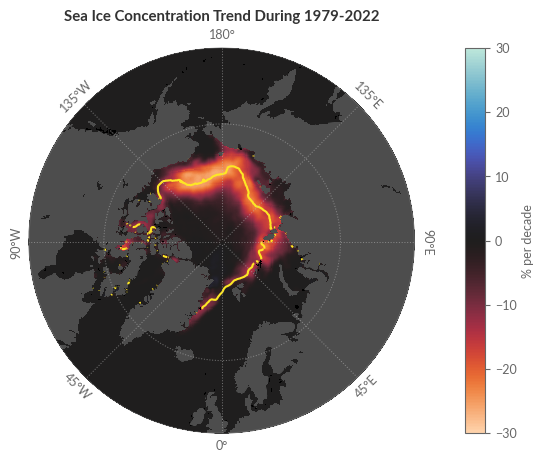

In [122]:
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, .05])
ax1 = fig.add_subplot(gs[0, 0], projection=proj_polar)
cax1 = fig.add_subplot(gs[0, 1])
axes = [ax1]
for ax in axes:
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    gl = ax.gridlines(zorder=5, ls=':', lw=.75, color='.75', alpha=.5, draw_labels=True)
    gl.xlocator = ticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135, 180])
    gl.ylocator = ticker.FixedLocator([30, 65, 90])

    ax.add_feature(cfeature.OCEAN, zorder=1, color='k')
    ax.add_feature(cfeature.LAND, zorder=2, color='.3')

    set_circle_boundary(ax)

bla_cbar_kws = dict(label='% per decade')
bla_kws = dict(vmin=-30, vmax=30, cmap='icefire_r', zorder=3, transform=proj_data, cbar_ax=cax1, cbar_kwargs=bla_cbar_kws)
trend.plot.pcolormesh(ax=ax1, **bla_kws)
cp = median_ice_edge.plot.contour(ax=ax1, levels=[.5], transform=proj_data, zorder=5)
labels = ['1991-2020 median ice edge']


for ax in axes:
    ax.set_title('')
    # Rotate the labels to simplify reading them
    rotate_labels_polar_plot(ax, gl)

ax1.set_title('Sea Ice Concentration Trend During 1979-2022', weight='bold', loc='center')
plt.show()

### Sea Ice Type
Our last segment aims to reproduce Figure 3 from the [Climate Indicators](https://climate.copernicus.eu/climate-indicators/sea-ice) section of the Climate Intelligence reports, illustrating sea ice extent based on its type.

Sea ice type categorises the sea ice cover into either first-year ice or multiyear ice, based on its survival past one melt season.

This sea ice type data is also accessible on the [CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=overview). For our illustration, we require data from January to March. Hence, we'll specify these months before using our established helper function to fetch the data.

In [76]:
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3]]  # Note: only Jan-Mar are downloaded

<div class="alert alert-block alert-warning">
<b>Caution</b>: <br>
   The subsequent cell will download approximately 10 GB. Ensure you have ample storage. The download may require several hours, contingent on your internet connection.
</div>

In [ ]:
download_loop_edge_type(client=client, variable='sea_ice_type', years=YEARS, months=MONTHS)

A brief overview of the dataset:

In [77]:
with xr.open_dataset("data/type/ice_type_nh_ease2-250_cdr-v2p0_197902011200.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:                 (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                    (time) datetime64[ns] 1979-02-01T12:00:00
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    time_bnds               (time, nv) datetime64[ns] ...
    ice_type                (time, yc, xc) float32 ...
    uncertainty             (time, yc, xc) float32 ...
    status_flag             (time, yc, xc) float32 ...
Attributes: (12/44)
    title:                     Sea Ice Type
    summary:                   Daily gridded Level-4 Sea Ice Type Climate Dat...
    comment:                   Northern Hemisphere sea ice type classificatio...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    ...                        ...
    processing_level:          Level-4 (l4)
    tracking_id:               43552121-b502-4672-877e-4807b5f50fb5
    doi:                       https://doi.org/10.24381/cds.29c46d83
    naming_authority:          no.met
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)

To optimise memory, we'll eliminate redundant variables and focus on `ice_type`.

In [78]:
def return_type_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_type']

In [79]:
ice_type = xr.open_mfdataset(path_to['ice_type'] + "/*.nc", preprocess=return_type_only)
ice_type['ice_type']

<xarray.DataArray 'ice_type' (time: 3376, yc: 432, xc: 432)>
dask.array<concatenate, shape=(3376, 432, 432), dtype=float32, chunksize=(1, 432, 432), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-03-31T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Attributes:
    long_name:            Classification of sea ice into the classes of first...
    standard_name:        sea_ice_classification
    valid_min:            1
    valid_max:            4
    grid_mapping:         Lambert_Azimuthal_Grid
    flag_values:          [1 2 3 4]
    flag_meanings:        open_water first_year_ice multi_year_ice ambiguous
    flag_descriptions:    flag 1: No ice or very open ice (less than 30% ice ...
    ancillary_variables:  uncertainty status_flag
    comment:              this field is the primary sea ice type estimate for...

Upon reviewing the attributes, we discern four distinct sea ice classifications:

- 1: **No ice** or very open ice (less than 30 % ice concentration)
- 2: **Seasonal ice** that has formed since lat melting season
- 3: **Older ice** that has survived at least one melting season
- 4: **Ambiguous ice** with non-significant classification

To replicate Figure 3's time series of Arctic average sea ice types, we first ascertain the **total daily sea ice area** linked with each sea ice type. We then use this to determine **monthly averages** and **3-month averages** spanning January to March.

We start by identifiying the common time steps in the ice concentration and ice type data sets. We could do this by simply selecting all data for the months of January to March, but we choose a more general way in case one data set has some missing values. We do this by converting the time coordinate of the sea ice concentration and ice type data into an index and take the intersection of both indices.

In [80]:
common_time_steps = sic.ice_conc.time.to_index().intersection(ice_type.ice_type.time.to_index())
sic_spring = sic["ice_conc"].sel(time=common_time_steps)
ice_type_spring = ice_type["ice_type"].sel(time=common_time_steps)

Next, we conver the daily sea ice concentration data into sea ice area by multiplying the concentration with the grid cell area.

In [81]:
ice_area_spring = (sic_spring / 100 * 25**2)  # divide by 100 because SIC is in %

Now, we convert the data set such that the ice type is represented as another dimension. This will facilitate the computation of the sea ice area for each ice type.

In [82]:
is_seasonal_ice = ice_type_spring == 2
is_multiyear_ice = ice_type_spring == 3
is_ambiguous_ice = ice_type_spring == 4
ice_categories = xr.concat([is_seasonal_ice, is_multiyear_ice, is_ambiguous_ice], dim="ice_type")
ice_categories.coords.update({"ice_type": ["seasonal", "multiyear", "ambiguous"]})
ice_categories

<xarray.DataArray 'ice_type' (ice_type: 3, time: 2539, yc: 432, xc: 432)>
dask.array<concatenate, shape=(3, 2539, 432, 432), dtype=bool, chunksize=(1, 1, 432, 432), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-03-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * ice_type  (ice_type) <U9 'seasonal' 'multiyear' 'ambiguous'

Now, we compute the total sea ice extent by sea ice type. For this, we need the daily **sea ice area** per grid cell and the corresponding sea ice type. The sea ice area is obtained by multiplying grid cell areas by their corresponding sea ice concentration. Then we can sum up the sea ice area for each sea ice type and each day, which can be represented as a dot product over the spatial dimensions `xc` and `yc`:

In [83]:
average_ice_types = xr.dot(
    ice_area_spring.fillna(0),  # fill NaNs by 0 to avoid NaNs in the result
    ice_categories,
    dims=['xc', 'yc']
)

Let's compute the `DataArray`:

In [84]:
with ProgressBar():
    average_ice_types = average_ice_types.compute()

[########################################] | 100% Completed | 86.15 s


Now, let's compute the average sea ice extent for each year by calculating the monthly average and then the mean over the months:

In [85]:
ice_extent_by_type = average_ice_types.resample(time='1M').mean()
ice_extent_by_type = ice_extent_by_type.groupby('time.year').mean('time')
ice_extent_by_type.name = 'ice_extent'

We convert the sea ice extent to million square kilometers:

In [86]:
ice_extent_by_type = ice_extent_by_type / 1.e6  # convert to Mkm^2

For visualising, we will bring the data into a form that is more convenient for plotting. For this, we will make use of `to_dateframe` method to convert the `sea_ice_extent` DataArray into a `pandas.DataFrame`:

In [87]:
ice_extent_df = ice_extent_by_type.to_dataframe().unstack('ice_type')['ice_extent']
ice_extent_df.head()

ice_type,seasonal,multiyear,ambiguous
year,,,
1979,7.186122,3.819843,0.491337
1980,6.942890,3.375394,0.843926
1981,6.023046,4.460483,0.450165
1982,7.324388,3.460484,0.478364
1983,6.805154,3.625870,0.675470


Let's also compute the relative sea ice extent per ice type:

In [88]:
rel_ice_extent_df = ice_extent_df.div(ice_extent_df.sum(axis=1), axis=0) * 100

Finally, we will use the median of the most recent data (Jan - Mar 2022) as a reference plot to be visuaprojected on a mini globe in the upper right corner of our final figure:

In [89]:
most_recent_data = ice_type['ice_type'].sel(time=slice('2022-01-01', '2022-03-31')).median('time')
most_recent_data = most_recent_data.compute()
most_recent_data.coords.update({"xc": most_recent_data.xc.values * 1000, "yc": most_recent_data.yc.values * 1000})

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


For visualizing different categories like ice types, we will use a categorical colormap.

In [90]:
colors = sns.color_palette("tab10", n_colors=5)

Now, we are ready to create our final plot in this notebook:

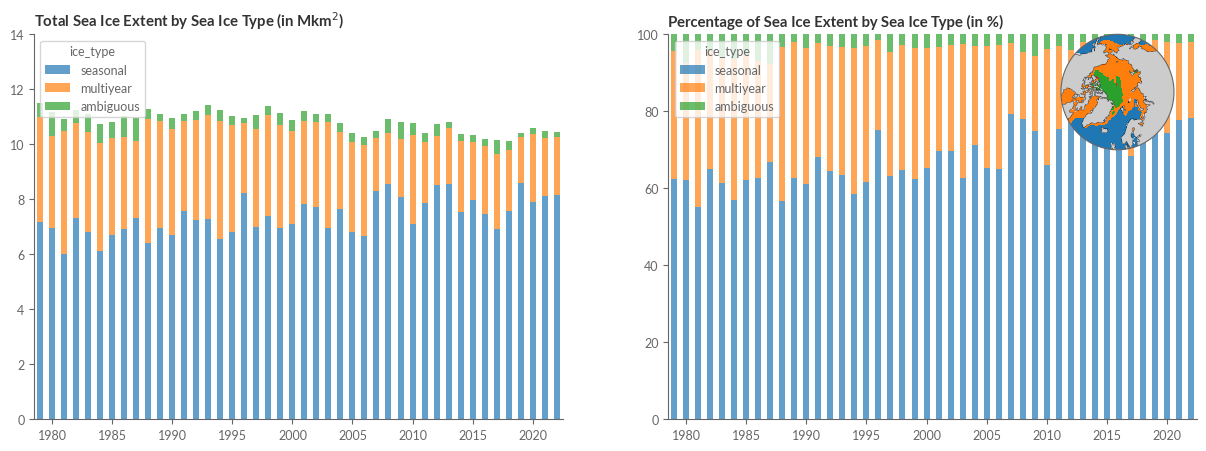

In [91]:
pad  = 0.0
w = 0.3
h = 0.3
n_years = ice_extent_df.shape[0]
xticks = np.arange(1, n_years, 5)
xticklabels = ice_extent_df.index[xticks]

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ice_extent_df.plot.bar(ax=ax1, stacked=True, xticks=xticks, color=colors, alpha=.7)
rel_ice_extent_df.plot.bar(ax=ax2, stacked=True, xticks=xticks, color=colors, alpha=.7)
for ax in [ax1, ax2]:
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Ice extent (Mkm$^2$)')
    sns.move_legend(ax, "upper left")

ax1.set_ylim(0, 14)
ax2.set_ylim(0, 100)

ax1.set_title('Total Sea Ice Extent by Sea Ice Type (in Mkm$^2$)', weight='bold')
ax2.set_title('Percentage of Sea Ice Extent by Sea Ice Type (in %)', weight='bold')

ax1.set_ylabel('')
ax2.set_ylabel('')

# Add a mini map of the Arctic to the upper right corner
a = ax2.get_position()
axins = fig.add_axes([a.x1-(w+pad)*a.width,a.y1-(h+pad)*a.height,w*a.width,h*a.height], projection=proj_polar)
axins.add_feature(cfeature.LAND, zorder=1, color='.8')
axins.coastlines('110m', lw=.25)
axins.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
most_recent_data.plot.contourf(ax=axins, transform=proj_data, add_colorbar=False, levels=[1.5, 2.5, 3.5], colors=colors)
set_circle_boundary(axins)

### Conclusion

This notebook centred on replicating visuals from the Climate Intelligence reports concerning sea ice. Specifically, we echoed illustrations from the sea ice sections of the Monthly Climate Bulletins and Climate Indicators. We demonstrated how to access and utilise data from the Climate Data Store, and where required, how to obtain data directly from the official data provider, EUMETSAT OSI SAF.